In [50]:
!vlc /home/alexander/Videos/CombOpt/03.30/BranchAndCut.mp4

VLC media player 3.0.1 Vetinari (revision 3.0.1-0-gec0f700fcc)
[0000555fe7422630] main libvlc: Running vlc with the default interface. Use 'cvlc' to use vlc without interface.
qt5ct: using qt5ct plugin
qt5ct: D-Bus global menu: no
qt5ct: D-Bus system tray: yes
libva info: VA-API version 1.1.0
libva info: va_getDriverName() returns 0
libva info: Trying to open /usr/lib/dri/i965_drv_video.so
libva info: va_openDriver() returns -1
[00007f83a8002be0] glconv_vaapi_x11 gl error: vaInitialize: unknown libva error
libva info: VA-API version 1.1.0
libva info: va_getDriverName() returns 0
libva info: Trying to open /usr/lib/dri/i965_drv_video.so
libva info: va_openDriver() returns -1
[00007f83a8002be0] glconv_vaapi_drm gl error: vaInitialize: unknown libva error
libva info: VA-API version 1.1.0
libva info: va_getDriverName() returns 0
libva info: Trying to open /usr/lib/dri/i965_drv_video.so
libva info: va_openDriver() returns -1
[00007f83a8002be0] glconv_vaapi_drm gl error: vaInitialize: unknow

In [19]:
def f(x, y):
    return x**2 + y

In [42]:
x = np.linspace(-0.2, 1.2, 100)
y = np.linspace(0, 5, 100)

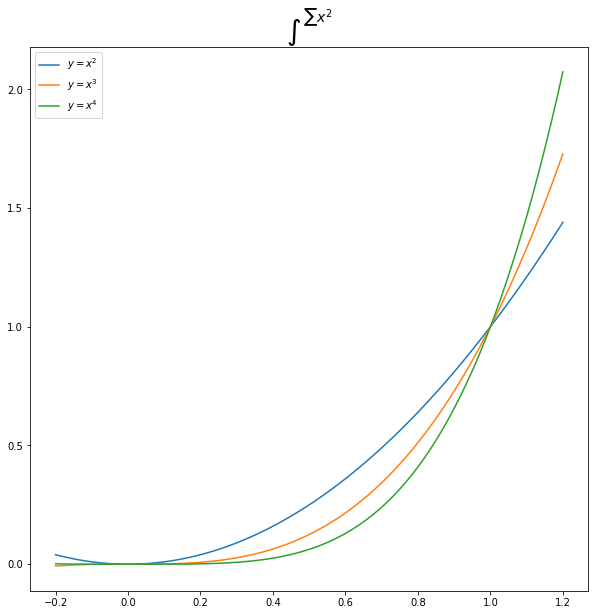

In [43]:
plt.figure(figsize=(10,10))
plt.title(r"$\int^{\sum x^2}$", fontsize=20)
for i in range(2,5):
    plt.plot(x, x**i, label=r"$y=x^{%i}$" % i)

plt.legend()

In [ ]:
API

In [21]:
plt.plot(x, y**2)
f(x[99], y)

array([25.        , 25.05050505, 25.1010101 , 25.15151515, 25.2020202 ,
       25.25252525, 25.3030303 , 25.35353535, 25.4040404 , 25.45454545,
       25.50505051, 25.55555556, 25.60606061, 25.65656566, 25.70707071,
       25.75757576, 25.80808081, 25.85858586, 25.90909091, 25.95959596,
       26.01010101, 26.06060606, 26.11111111, 26.16161616, 26.21212121,
       26.26262626, 26.31313131, 26.36363636, 26.41414141, 26.46464646,
       26.51515152, 26.56565657, 26.61616162, 26.66666667, 26.71717172,
       26.76767677, 26.81818182, 26.86868687, 26.91919192, 26.96969697,
       27.02020202, 27.07070707, 27.12121212, 27.17171717, 27.22222222,
       27.27272727, 27.32323232, 27.37373737, 27.42424242, 27.47474747,
       27.52525253, 27.57575758, 27.62626263, 27.67676768, 27.72727273,
       27.77777778, 27.82828283, 27.87878788, 27.92929293, 27.97979798,
       28.03030303, 28.08080808, 28.13131313, 28.18181818, 28.23232323,
       28.28282828, 28.33333333, 28.38383838, 28.43434343, 28.48

In [8]:
# from joblib import Parallel, delayed

import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

# import sympy
import scipy
import scipy.optimize
import scipy.special
import scipy.misc
import scipy.integrate as integrate
import scipy.interpolate as interpolate

# import seaborn as sns
# sns.set()

EPS = 1e-9

from tqdm import tqdm as tqdm

## Classes for densities  etc

In [2]:
class Function:
    def __init__(self, 
                 lambda_f,
                 bounds):
        self.lambda_f = lambda_f
        self.left_bound = bounds[0] - EPS
        self.right_bound = bounds[1] + EPS
    
    def __call__(self, x):
        x = np.asarray(x)

        if np.logical_or((x < self.left_bound).any(), (x > self.right_bound).any()):
            raise Exception("Wrong x")            

        return self.lambda_f(x)

class CDF:
    def __init__(self, 
                 lambda_f = lambda x : x,
                 bounds = [0, 1]):
        self.left_bound = bounds[0]
        self.right_bound = bounds[1]
        
        self.lambda_f = lambda_f
        
    def __call__(self, x):
        x = np.asarray(x)
        try:
            return np.where(x < self.left_bound,
                              0,
                              np.where(x > self.right_bound, 1, self.lambda_f(x)))
        except:
#             print("Slow function called in CDF")
            ans = []
            for x_ in x:
                if x_ < self.left_bound:
                    ans.append(0)
                elif x_ > self.right_bound:
                    ans.append(1)
                else:
                    ans.append(self.lambda_f(x_))
            return np.array(ans)
        
    
class PDF:
    def __init__(self, 
                 lambda_f = lambda x : x,
                 bounds = [0, 1]):
        self.left_bound = bounds[0]
        self.right_bound = bounds[1]
        
        self.lambda_f = lambda_f
        
    def __call__(self, x):
        x = np.asarray(x)
        
        return np.where(np.logical_or(x < self.left_bound, x > self.right_bound),
                          0,
                          self.lambda_f(x))

class UniformCDF(CDF):
    def __init__(self,  bounds=[0, 1]):
        l = bounds[0]
        r = bounds[1]
        super().__init__(lambda x : (x - l) / (r - l), bounds)
        
class UniformPDF(PDF):
    def __init__(self,  bounds=[0, 1]):
        l = bounds[0]
        r = bounds[1]
        super().__init__(lambda x : 1. / (r - l), bounds)

def Derivative(function_with_call):
    derivative = lambda x  : scipy.misc.derivative(function_with_call, x,  dx=1e-8)
    return Function(lambda_f=derivative,
                          bounds=[function_with_call.left_bound,
                                  function_with_call.right_bound])
    
def CDF_to_PDF(function_with_call):
    assert isinstance(function_with_call, CDF)
    derivative = lambda x  : scipy.misc.derivative(function_with_call, x,  dx=1e-8)

    return PDF(lambda_f=derivative,
                          bounds=[function_with_call.left_bound,
                                  function_with_call.right_bound])

class Power:
    def __init__(self, f, n):
        self.f = f
        self.n = n
        
    def __call__(self,  x):
        return np.power(self.f(x), self.n) 

def k_statistics_PDF(k, n, F, f=None):
    if not f:
        f = CDF_to_PDF(F)
        
    lambda_f = lambda x : scipy.special.comb(n, k) * k * (F(x) ** (k - 1)) * ((1 - F(x)) ** (n - k)) * f(x)
    return PDF(lambda_f = lambda_f, bounds=[F.left_bound, F.right_bound])


def k_statistics_CDF(k, n, F):
    
    def lambda_f(x):
        ans = 0
        for i in range(k, n+1):
            ans += scipy.special.comb(n, i) * (F(x) ** i) * ((1 - F(x)) ** (n - i))
        return ans    
        
    return CDF(lambda_f = lambda_f, bounds=[F.left_bound, F.right_bound])


def Integrate(f, a, b, n=1000):
    x = np.linspace(a, b, n)
    y = [integrate.quad(f, a, t)[0]
                   for t in x
    ]
    
    return interpolate.interp1d(x, y, fill_value="extrapolate", assume_sorted=True)

def PDF_to_CDF(f):
    assert isinstance(f, PDF), "f must be PDF"
    lambda_ = Integrate(f, f.left_bound + EPS, f.right_bound - EPS)
    
    
    return CDF(lambda_,
                    [f.left_bound, f.right_bound])

In [49]:
uniform_cdf = UniformCDF([0, 1])
uniform_pdf = CDF_to_PDF(uniform_cdf)
uniform_order_3_10 = k_statistics_PDF(3, 10,  uniform_cdf)
uniform_order_10_10 = k_statistics_PDF(10, 10,  uniform_cdf)

In [50]:
uniform_order_3_10_cdf = k_statistics_CDF(3, 10, uniform_cdf)

In [51]:
isinstance(uniform_order_3_10, PDF)

True

In [52]:
int_x = PDF_to_CDF(uniform_order_3_10)

In [53]:
isinstance(uniform_order_3_10, PDF)

True

In [54]:
print(repr(uniform_order_3_10))

In [55]:
x = np.linspace(0, 2)

In [69]:
import scipy.stats

In [91]:
n = 50
p1 = 0.3
p2 = 0.4

In [92]:
x = np.arange(0, n + 1)

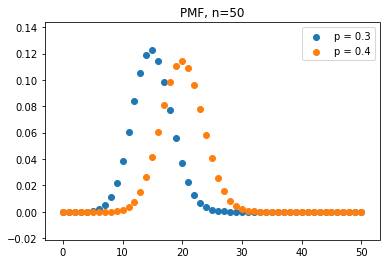

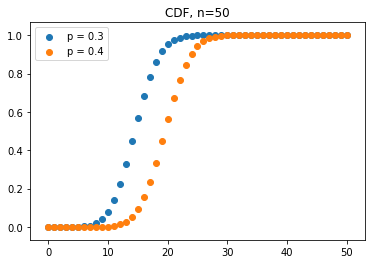

In [112]:
# plt.figure(figsize=(12,8))

plt.title("PMF, n=%s" %n)
plt.scatter(x, scipy.stats.binom.pmf(x, n, p1), label="p = %s" % p1)
plt.scatter(x, scipy.stats.binom.pmf(x, n, p2), label="p = %s" % p2)
plt.legend()
plt.show()

# plt.figure(figsize=(12,8))

plt.title("CDF, n=%s" %n)
plt.scatter(x, scipy.stats.binom.cdf(x, n, p1), label="p = %s" % p1)
plt.scatter(x, scipy.stats.binom.cdf(x, n, p2), label="p = %s" % p2)
plt.legend()
plt.show()

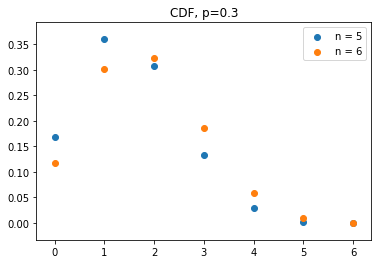

In [128]:
# plt.figure(figsize=(12,8))

# plt.title("PMF, n=%s" %n)
# plt.scatter(x, scipy.stats.binom.pmf(x, n, p1), label="p = %s" % p1)
# plt.scatter(x, scipy.stats.binom.pmf(x, n, p2), label="p = %s" % p2)
# plt.legend()

# plt.figure(figsize=(12,8))
n = 5
x = np.arange(0, n+2)
plt.title("CDF, p=%s" % p1)
plt.scatter(x, scipy.stats.binom.pmf(x, n, p1), label="n = %i" % n)
plt.scatter(x, scipy.stats.binom.pmf(x, n+1, p1), label="n = %i" % (n+1))
plt.legend()

Properties about order statistics


CDF is:
$$F_{k,n}(x) = \sum_{i=k}^n \binom{n}{i} F^i(x) (1 - F(x))^{n - i}$$

It looks (and actually is) as a binomial distribution with $p = F(x)$ and then we can rewrite the sum above as (using substitution $k' = k - 1$ and representation in terms of the regularized incomplete beta function)

$$1 - F_{Binom}(k-1;n;p) = 1 - (n - k') \binom{n}{k'} \int_0^{1-p} t^{n-k'-1}(1-t)^{k'} \diff t$$

1) $F_{k, n} < F_{k+1, n}$ Obvious -- one more positive term is a sum.

2) $F_{k, n+1} < F_{k, n}$ ???


3) Let $F < G$ in terms first order stochastic dominance. Then $F_{k,n} < G_{k,n}$ for any $k$.

Let  
$$F(t) = p_1 < p_2 = G(t)$$

We want to show that  
$$F_{k + 1,n} < G_{k + 1,n}$$

Using regularized incomplete beta function form:

$$1 - (n - k) \binom{n}{k} \int_0^{1-p_1} t^{n-k-1}(1-t)^k \diff t < 1 - (n - k) \binom{n}{k} \int_0^{1-p_2} t^{n-k-1}(1-t)^k \diff t \Leftarrow$$

$$(n - k) \binom{n}{k} \int_0^{1-p_1} t^{n-k-1}(1-t)^k \diff t > (n - k) \binom{n}{k} \int_0^{1-p_2} t^{n-k-1}(1-t)^k \diff t$$

$$\int_0^{1-p_1} t^{n-k-1}(1-t)^k \diff t > \int_0^{1-p_2} t^{n-k-1}(1-t)^k \diff t$$

$$\int_{1-p_2}^{1-p_1} t^{n-k-1}(1-t)^k \diff t > 0$$

In [65]:
def two_deltas(x, a=0.5, b=0.9):
    step = 0.1
    
    if x < a:
        return 0
    if x < a + step:
        return (x - a) * 0.5 / step
    if x < b:
        return 0.5
    if x < b + step:
        return 0.5 + (x - b) * 0.5 / step
    return 1

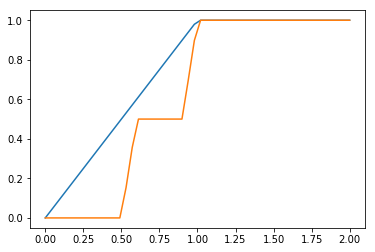

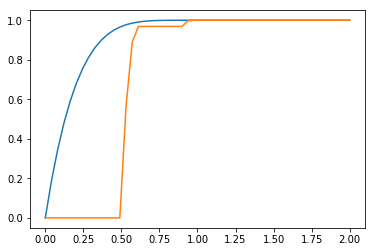

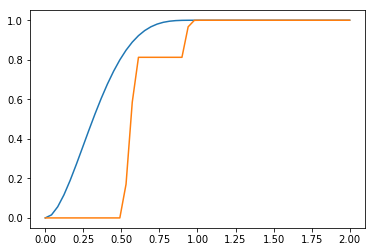

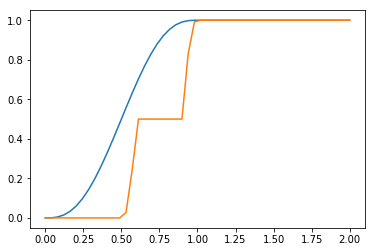

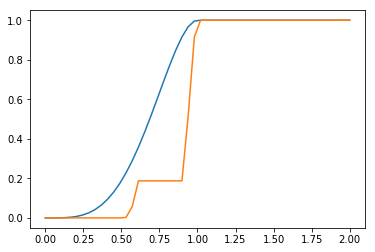

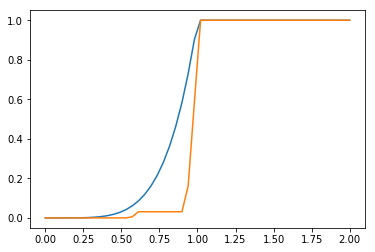

In [67]:
CDF_1 = UniformCDF([0, 1])
CDF_2 = CDF(two_deltas, bounds=[0, 1.5])

plt.plot(x, CDF_1(x))
plt.plot(x, CDF_2(x))
plt.show()


for i in range(1, n + 1):
    plt.plot(x, k_statistics_CDF(i, n, CDF_1)(x), label="CDF1 " + str(i))
    plt.plot(x, k_statistics_CDF(i, n, CDF_2)(x), label="CDF2 " + str(i))
#     plt.plot(x, k_statistics_PDF(i, n, CDF_1)(x), label="PDF1 " + str(i))
#     plt.plot(x, k_statistics_PDF(i, n, CDF_2)(x), label="PDF2 " + str(i))
    plt.show()

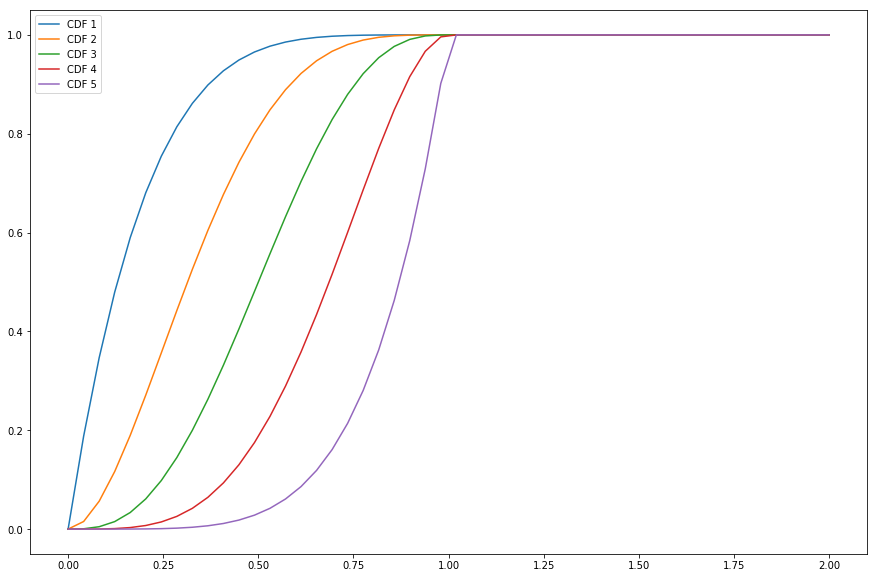

In [44]:
plt.figure(figsize=(15, 10))

n = 5

for i in range(1, n + 1):
    plt.plot(x, k_statistics_CDF(i, n, uniform_cdf)(x), label="CDF " + str(i))
#     plt.plot(x, k_statistics_PDF(i, n, uniform_cdf)(x), label="PDF " + str(i))

# plt.plot(x, uniform_order_3_10(x), label="PDF")
# plt.plot(x, int_x(x), label="PDF")
plt.legend()

### Sanity checks

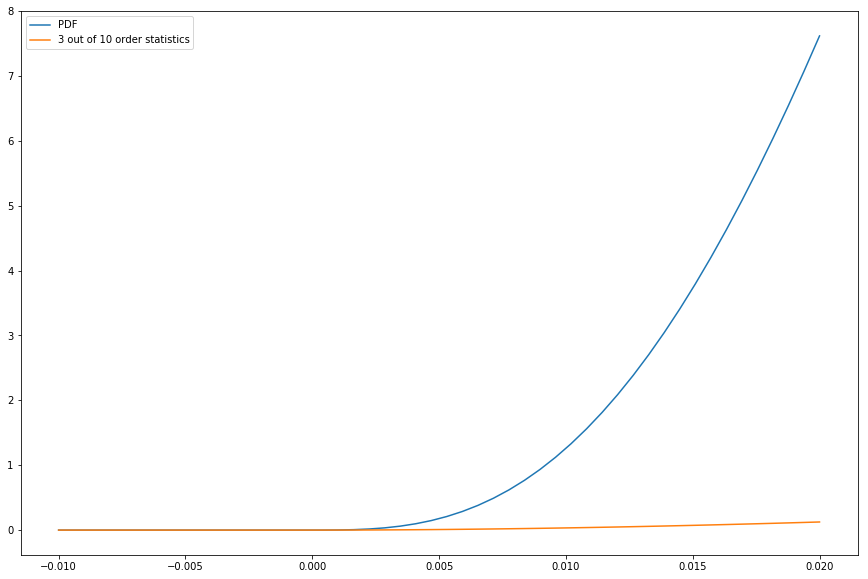

In [157]:


plt.figure(figsize=(15, 10))
# plt.plot(x, uniform_cdf(x), label="CDF")
plt.plot(x, new(x), label="PDF")
plt.plot(x, uniform_order_3_10(x), label="3 out of 10 order statistics")
# plt.plot(x, uniform_order_10_10(x), label="10 out of 10 order statistics")
plt.legend()

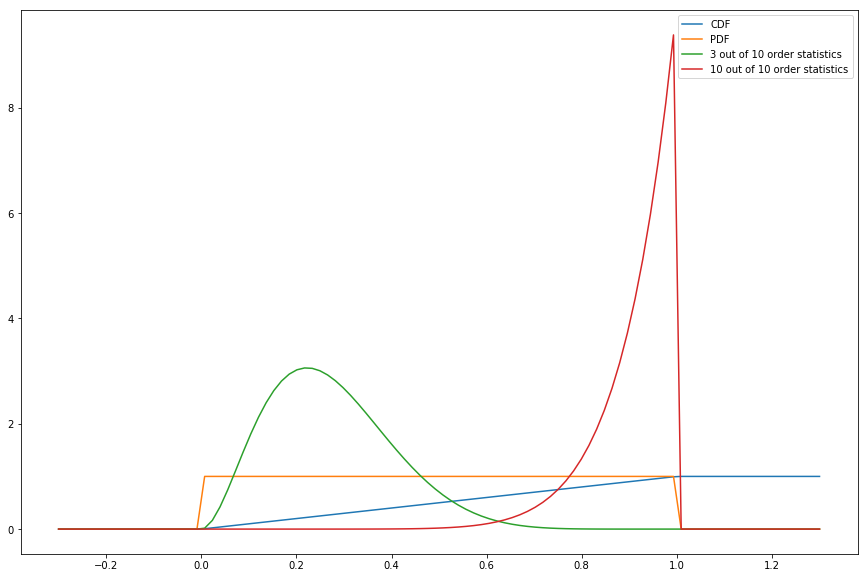

In [7]:
uniform_cdf = MakeUniformCDF([0, 1])
uniform_pdf = MakeDensity(uniform_cdf)
uniform_order_3_10 = get_k_statistics_density(3, 10,  uniform_cdf)
uniform_order_10_10 = get_k_statistics_density(10, 10,  uniform_cdf)

x = np.linspace(-0.3, 1.3, 100)

plt.figure(figsize=(15, 10))
plt.plot(x, uniform_cdf(x), label="CDF")
plt.plot(x, uniform_pdf(x), label="PDF")
plt.plot(x, uniform_order_3_10(x), label="3 out of 10 order statistics")
plt.plot(x, uniform_order_10_10(x), label="10 out of 10 order statistics")
plt.legend()

In [9]:
integrate.quad(lambda x : x * uniform_order_3_10(x), 0, 10)[0] - 3/11

-4.2032488600796114e-12

## Solution for our problem

### PriceOverDerivative calculation

In [3]:
class PriceOverDerivative:
    def __init__(self, n):
        self.n = n
    
    def __call__(self, x):
        x = np.asarray(x)
        return (1 - np.power(x, self.n)) / x
    
    def solve(self, rhs, x_0=0.3):
        solution = scipy.optimize.newton(lambda  x: self.__call__(x) - rhs, x_0)
        
        if self.__call__(solution) - rhs > 0.001:
            raise Exception("solve failed")
        
        return solution  

### Calculation of sum of integrals (left hand side)

In [4]:
def GetValuesForSameSearhCosts(n, G=None, f=None):
    if not G:
        G = MakeUniformCDF([0, 0.1])
    
    g = MakeDensity(G)
        
    if not f:
        f = CreatePDF(lambda x: 1 - np.sqrt(2 * x), [0, 0.5])
    
    values = np.array([integrate.quad(lambda x : MakePower(f, i)(x) * g(x), 0, 0.5) for i in range(n)])
    
    errors = values[:, 1]
    values = values[:, 0]
    return values, errors

def GetValuesForDifferentSearhCosts(n, G=None, f=None):
    if not G:
        G = MakeUniformCDF([0, 0.1])
    
    g = MakeDensity(G)
    
    if not f:
        f = CreatePDF(lambda x: 1 - np.sqrt(2 * x), [0, 0.5])

    values = np.zeros((n, 2))
    
    for i in range(n):
        g_current = get_k_statistics_density(i + 1, n, G)
        values[i] = integrate.quad(lambda x : MakePower(f, i)(x) * g_current(x), 0, 0.5)
    
    errors = values[:, 1]
    values = values[:, 0]
    
    return values, errors

# x, _ = GetValuesForSameSearhCosts(7, G=MakeUniformCDF([0, 0.02]))
# x, _ = GetValuesForDifferentSearhCosts(7)
# x.sum()

### Merge everything here

In [5]:
def solution_for_same_and_different_search_costs(n, G=None, verbose=False):
    if n < 1:
        print(n)
        raise Exception("choose n > 1")
        
    POD = PriceOverDerivative(n)
    
    f = CreatePDF(lambda x: 1 - np.sqrt(2 * x), [0, 0.5])    

    if not G:
        G = MakeUniformCDF([0, 0.1])
    
    rhs, errors = GetValuesForSameSearhCosts(n, G=G, f=f)
    rhs_sum = rhs.sum()
    error = errors.sum()
    same_prices = POD.solve(rhs_sum, 0.3)

    if verbose:
        print("Same search costs case:")
        print("RHS =",  rhs_sum)
        print(same_prices)
    #     print(POD.solve(rhs_sum - 5 * error, 0.4), POD.solve(rhs_sum + 5 * error, 0.4))
        print()

    rhs_2, errors = GetValuesForDifferentSearhCosts(n, G=G, f=f)
    rhs_2_sum = rhs_2.sum()
    error = errors.sum()
    different_prices = POD.solve(rhs_2_sum, 0.3)
    
    if verbose:
        print("Different search costs case:")
        print("RHS =",  rhs_2_sum)
        print(different_prices)
    #     print(POD.solve(rhs_2_sum - 5 * error, 0.4), POD.solve(rhs_2_sum + 5 * error, 0.4))

    return same_prices, different_prices
    
#     return rhs, rhs_2

def vectors_for_same_search_costs(n, G=None):
    if n < 1:
        print(n)
        raise Exception("choose n > 1")
        
    f = CreatePDF(lambda x: 1 - np.sqrt(2 * x), [0, 0.5])    

    if not G:
        G = MakeUniformCDF([0, 0.1])
    
    rhs_2, errors = GetValuesForSameSearhCosts(n, G=G, f=f)
    
    return rhs_2

def vectors_for_different_search_costs(n, G=None):
    if n < 1:
        print(n)
        raise Exception("choose n > 1")
        
    f = CreatePDF(lambda x: 1 - np.sqrt(2 * x), [0, 0.5])    

    if not G:
        G = MakeUniformCDF([0, 0.1])
    
    rhs_2, errors = GetValuesForDifferentSearhCosts(n, G=G, f=f)
    
    return rhs_2

## Computation of elemens of sum

## START HERE

In [14]:
# use this for upper limit
n = 70

In [16]:
def ComputeVectorsAndSums(n, G):
    different_prices_vec = [vectors_for_different_search_costs(i, G) for i in range(1, n)]

    different_prices_vec = np.array(different_prices_vec)

    same_prices_vec_tmp =  vectors_for_same_search_costs(n, G)

    same_prices_vec = []
    for i in range(1, n):
        same_prices_vec.append(same_prices_vec_tmp[:i])

    same_prices_vec = np.array(same_prices_vec)

    same_prices_vec_sum = []
    diff_prices_vec_sum = []

    for i in range(len(same_prices_vec)):
        same_prices_vec_sum.append(same_prices_vec[i].sum())
        diff_prices_vec_sum.append(different_prices_vec[i].sum())

    same_prices_vec_sum = np.array(same_prices_vec_sum)
    diff_prices_vec_sum = np.array(diff_prices_vec_sum)
    
    return different_prices_vec, same_prices_vec, diff_prices_vec_sum, same_prices_vec_sum

In [17]:
different_prices_vec, same_prices_vec, diff_prices_vec_sum, same_prices_vec_sum = ComputeVectorsAndSums(n,
                                                                                                   MakeUniformCDF([0, 0.1]))

### Plots start here

### D_i vs S_i

In [18]:
k = 40

assert k < n
same = same_prices_vec_sum[:k]
diff = diff_prices_vec_sum[:k]

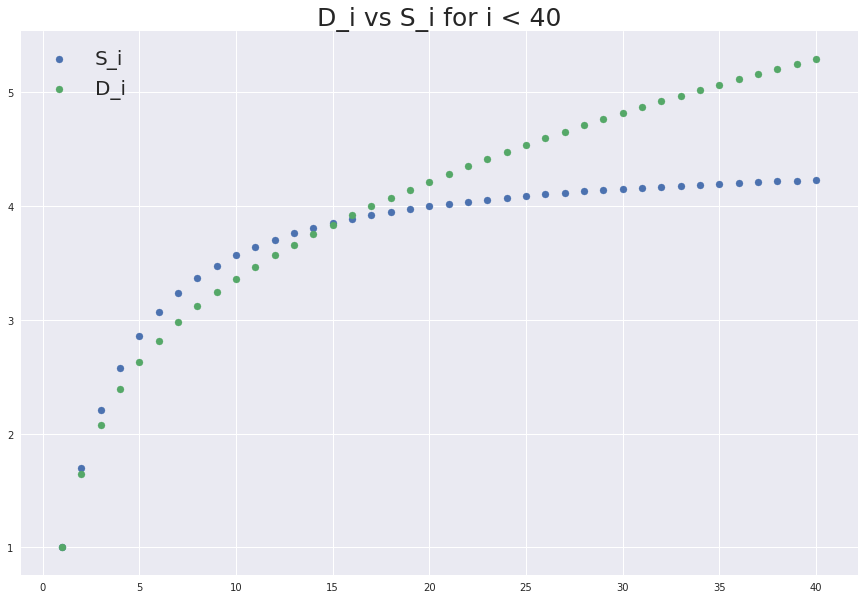

In [19]:
plt.figure(figsize=(15, 10))
plt.title("D_i vs S_i for i < %i" % k, fontsize=25)

plt.scatter(range(1, k + 1), same, label="S_i")
plt.scatter(range(1, k + 1), diff, label="D_i")

plt.legend(fontsize=20)

### Plot elements of sums for different n

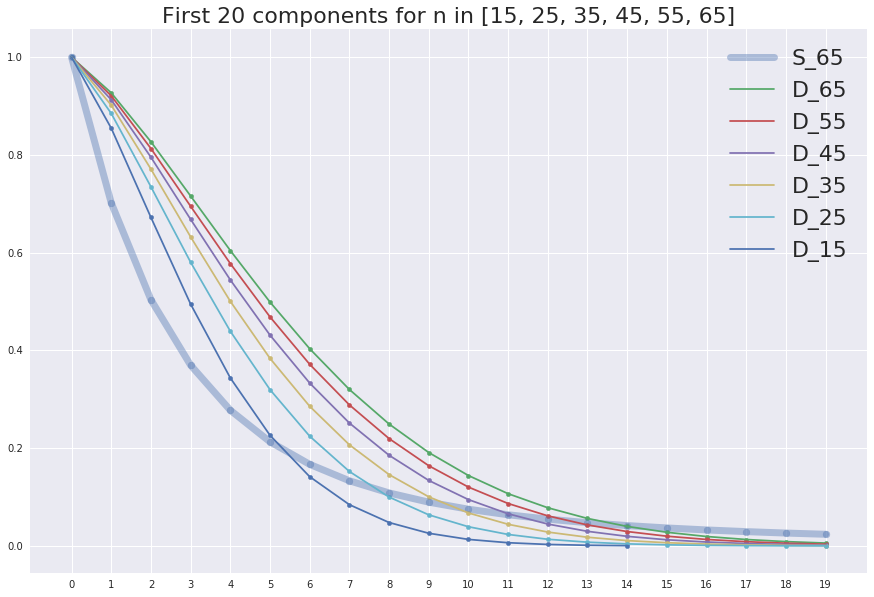

In [52]:
indices = [15, 25, 35, 45, 55, 65]
border = 20

plt.figure(figsize=(15, 10))
plt.title("First " + str(border) + " components for n in " + str(indices), fontsize=22)
plt.xticks(range(border))

plt.plot(range(border), same_prices_vec[border - 1], label="S_%i" % max(indices), linewidth=7.0, alpha=0.4)
plt.scatter(range(border), same_prices_vec[border - 1], alpha=0.4)

for i in indices[::-1]:
    cur_border = min(border, i)
    plt.plot(range(cur_border), different_prices_vec[i][:cur_border], label="D_"+str(i))
    plt.scatter(range(cur_border), different_prices_vec[i][:cur_border], s=20)
    
plt.legend(fontsize=22)
plt.show()

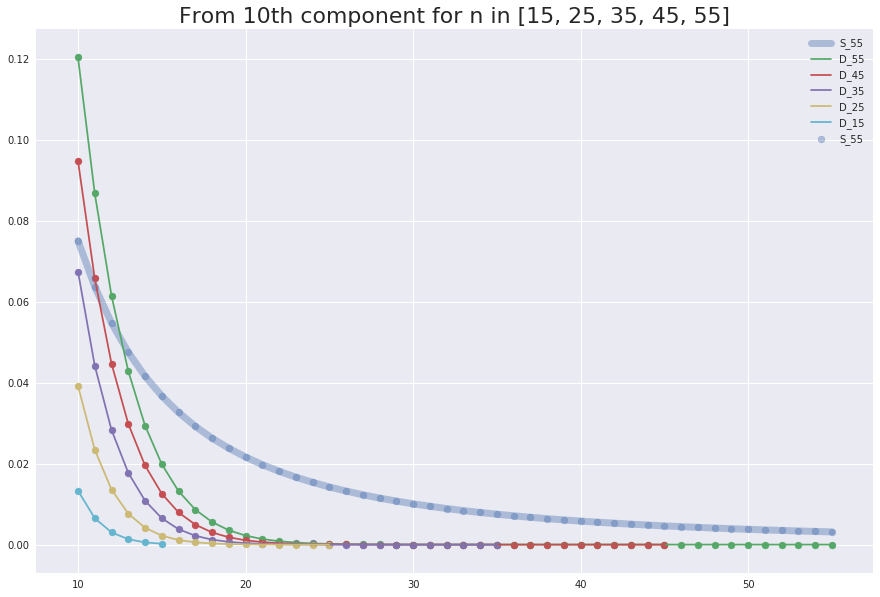

In [50]:
indices = [15, 25, 35, 45, 55]

border = 10

plt.figure(figsize=(15, 10))
plt.title("From " + str(border) + "th component for n in " + str(indices), fontsize=22)

plt.plot(range(border, max(indices) + 1), same_prices_vec[max(indices)][border:], label="S_%i" % max(indices), linewidth=7.0, alpha=0.4)
plt.scatter(range(border, max(indices) + 1), same_prices_vec[max(indices)][border:], label="S_%i" % max(indices), alpha=0.4)


max_ind = max(indices)
for i in indices[::-1]:
    if i > border:
        plt.plot(range(border, i + 1), different_prices_vec[i][border:], label="D_" + str(i))
        plt.scatter(range(border, i + 1), different_prices_vec[i][border:])
    
plt.legend()
plt.show()

## Same plots for other G = U[0.05, 0.1]

In [53]:
n

70

In [54]:
different_prices_vec, same_prices_vec, diff_prices_vec_sum, same_prices_vec_sum = ComputeVectorsAndSums(n,
                                                                                                   MakeUniformCDF([0.05, 0.1]))

### Plots start here

### D_i vs S_i

In [55]:
k = 40

assert k < n
same = same_prices_vec_sum[:k]
diff = diff_prices_vec_sum[:k]

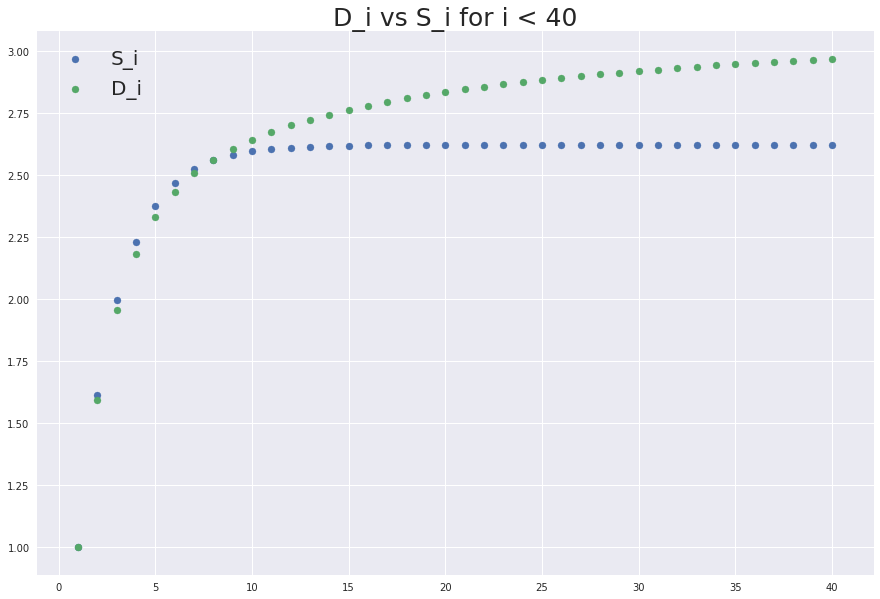

In [56]:
plt.figure(figsize=(15, 10))
plt.title("D_i vs S_i for i < %i" % k, fontsize=25)

plt.scatter(range(1, k + 1), same, label="S_i")
plt.scatter(range(1, k + 1), diff, label="D_i")

plt.legend(fontsize=20)

### Plot elements of sums for different n

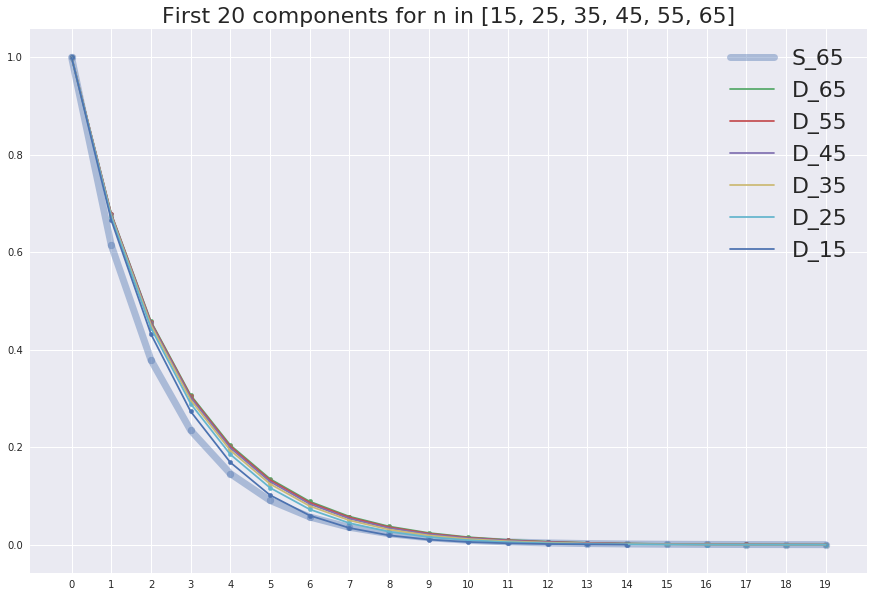

In [57]:
indices = [15, 25, 35, 45, 55, 65]
border = 20

plt.figure(figsize=(15, 10))
plt.title("First " + str(border) + " components for n in " + str(indices), fontsize=22)
plt.xticks(range(border))

plt.plot(range(border), same_prices_vec[border - 1], label="S_%i" % max(indices), linewidth=7.0, alpha=0.4)
plt.scatter(range(border), same_prices_vec[border - 1], alpha=0.4)

for i in indices[::-1]:
    cur_border = min(border, i)
    plt.plot(range(cur_border), different_prices_vec[i][:cur_border], label="D_"+str(i))
    plt.scatter(range(cur_border), different_prices_vec[i][:cur_border], s=20)
    
plt.legend(fontsize=22)
plt.show()

In [63]:
18 / 24 * 44

33.0

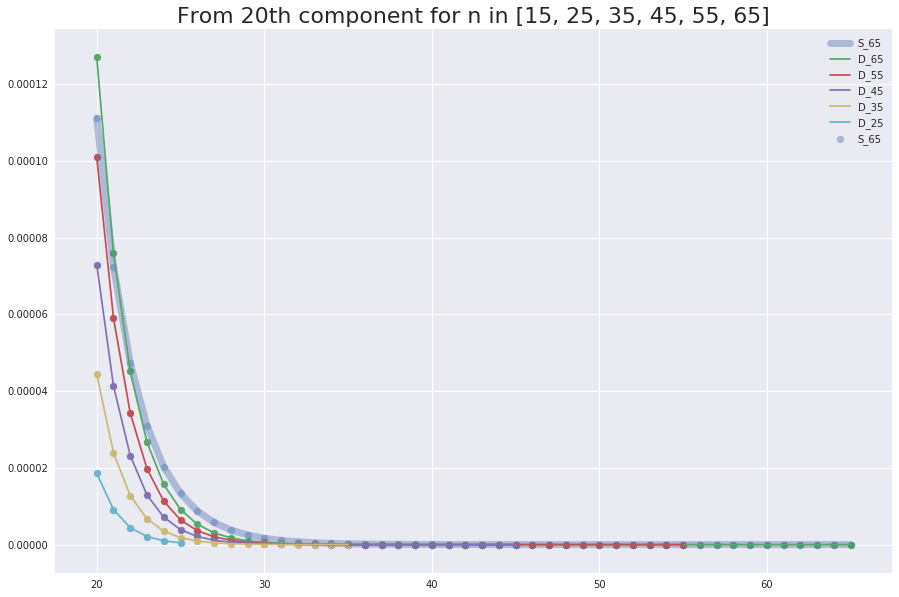

In [61]:
indices = [15, 25, 35, 45, 55, 65]

border = 20

plt.figure(figsize=(15, 10))
plt.title("From " + str(border) + "th component for n in " + str(indices), fontsize=22)

plt.plot(range(border, max(indices) + 1), same_prices_vec[max(indices)][border:], label="S_%i" % max(indices), linewidth=7.0, alpha=0.4)
plt.scatter(range(border, max(indices) + 1), same_prices_vec[max(indices)][border:], label="S_%i" % max(indices), alpha=0.4)


max_ind = max(indices)
for i in indices[::-1]:
    if i > border:
        plt.plot(range(border, i + 1), different_prices_vec[i][border:], label="D_" + str(i))
        plt.scatter(range(border, i + 1), different_prices_vec[i][border:])
    
plt.legend()
plt.show()

## Plots for optimal prices

In [73]:
same_prices_vec = []
different_prices_vec = []

n = 70
for i in tqdm(range(1, n)):
    x, y = solution_for_same_and_different_search_costs(i)
    same_prices_vec.append(x)
    different_prices_vec.append(y)

100%|██████████| 69/69 [02:17<00:00,  1.99s/it]


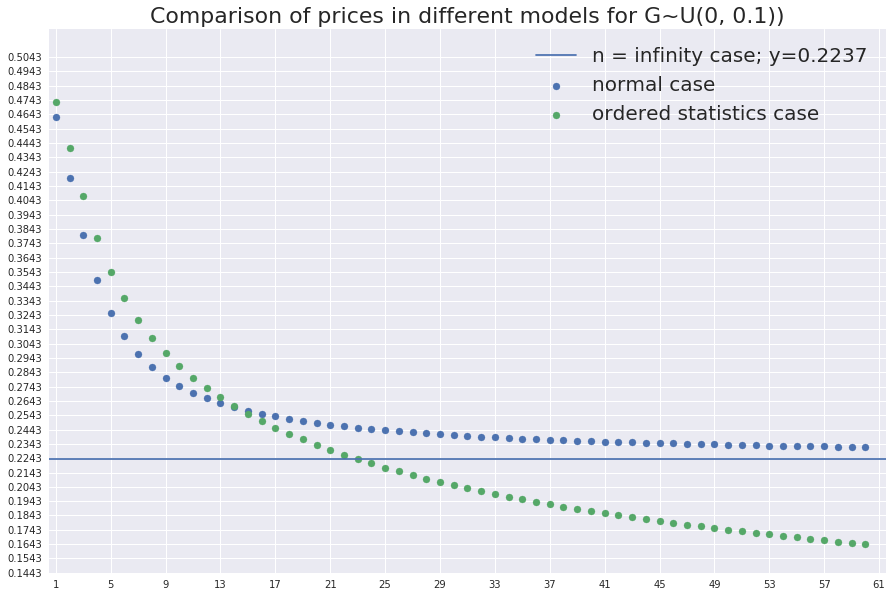

In [82]:
n = n - 1
plt.figure(figsize=(15, 10))
plt.scatter(range(n), same_prices_vec[:n], label="normal case")
plt.scatter(range(n), different_prices_vec[:n], label="ordered statistics case")
plt.xticks(np.arange(1, n + 1, 4))
plt.xlim(1 - 0.5, n + .5)

plt.axhline(y=0.2237, label="n = infinity case; y=0.2237")

min1 = min(same_prices_vec[:n])
min2 = min(different_prices_vec[:n])


plt.title("Comparison of prices in different models for G~U(0, 0.1))", fontsize=22)
plt.yticks(np.arange(min(min1, min2) - 0.02, 0.51, 0.01))

plt.legend(fontsize=20)

In [70]:
same_prices_vec = []
different_prices_vec = []

n = 40
for i in tqdm(range(1, n)):
    x, y = solution_for_same_and_different_search_costs(i, G=MakeUniformCDF(bounds=[0, 0.05]))
    same_prices_vec.append(x)
    different_prices_vec.append(y)

100%|██████████| 39/39 [01:18<00:00,  2.02s/it]


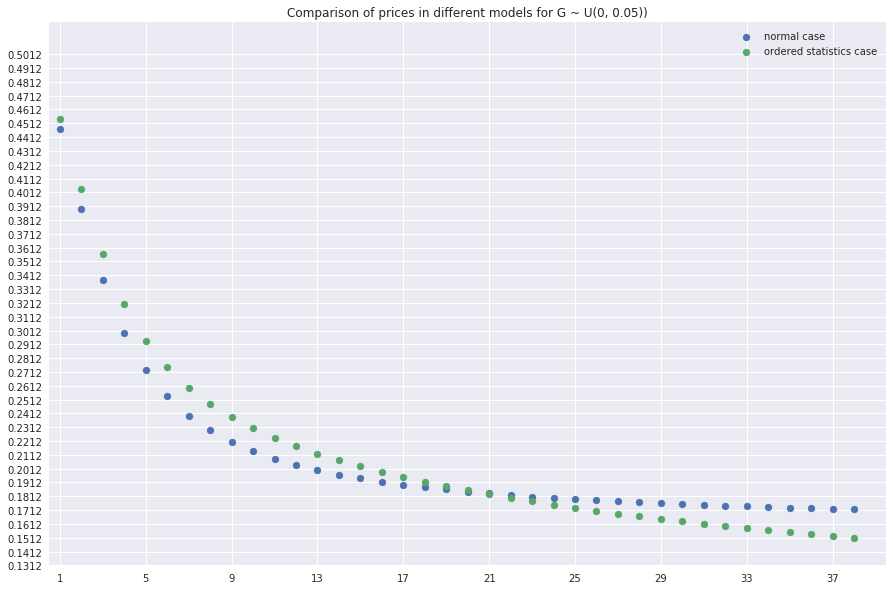

In [71]:
n = n - 1
plt.figure(figsize=(15, 10))
plt.scatter(range(n), same_prices_vec[:n], label="normal case")
plt.scatter(range(n), different_prices_vec[:n], label="ordered statistics case")
plt.xticks(np.arange(1, n + 1, 4))
plt.xlim(1 - 0.5, n + .5)

min1 = min(same_prices_vec[:n])
min2 = min(different_prices_vec[:n])


plt.title("Comparison of prices in different models for G ~ U(0, 0.05))")
plt.yticks(np.arange(min(min1, min2) - 0.02, 0.51, 0.01))

plt.legend()

In [ ]:
same_prices_vec = []
different_prices_vec = []

n = 40
for i in tqdm(range(1, n)):
    x, y = solution_for_same_and_different_search_costs(i, G=MakeUniformCDF(bounds=[0.05, 0.1]))
    same_prices_vec.append(x)
    different_prices_vec.append(y)

    

100%|██████████| 39/39 [01:25<00:00,  2.20s/it]


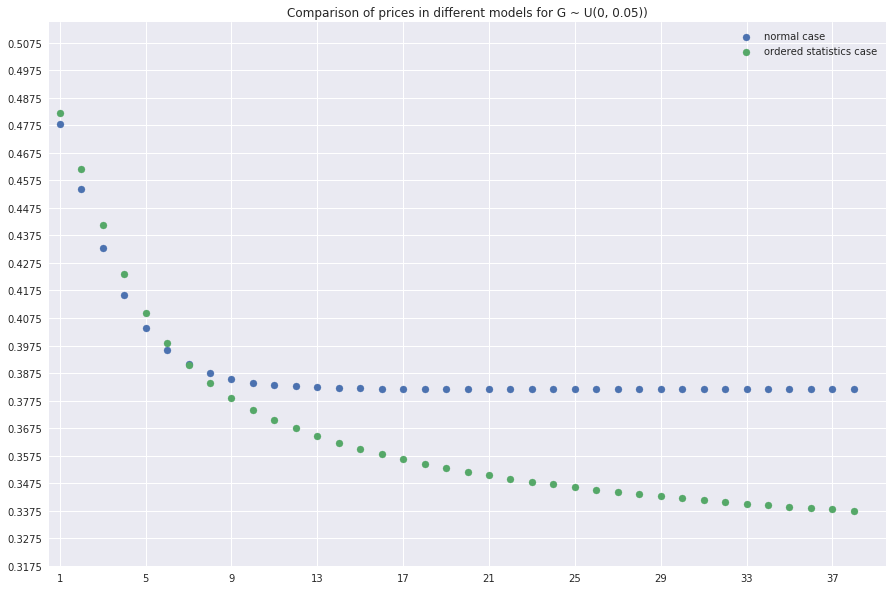

In [72]:
n = n - 1
plt.figure(figsize=(15, 10))
plt.scatter(range(n), same_prices_vec[:n], label="normal case")
plt.scatter(range(n), different_prices_vec[:n], label="ordered statistics case")
plt.xticks(np.arange(1, n + 1, 4))
plt.xlim(1 - 0.5, n + .5)

min1 = min(same_prices_vec[:n])
min2 = min(different_prices_vec[:n])


plt.title("Comparison of prices in different models for G ~ U(0.05, 0.1))")
plt.yticks(np.arange(min(min1, min2) - 0.02, 0.51, 0.01))

plt.legend()

## Derivation of H_i


In [13]:
interpolate.interp1d

scipy.interpolate.interpolate.interp1d

In [14]:
from scipy import interp

In [6]:
def Get_x_hat(F, verbose=False):
    one_minus_F = lambda x : 1 - F(x)
    
    if verbose:
        plt.figure(figsize=(16, 10))
        x = np.linspace(-0.1, 2, 100)
        plt.plot(x, F(x), label="F(x)")
        plt.plot(x, one_minus_F(x), label="1 - F(x)")
    
    
    x = np.linspace(-0.1, F.right_bound + 1, 500)
    y = [integrate.quad(one_minus_F, max(0.,t), F.right_bound + 1)[0]
                       for t in x
        ]
    
    
    x_hat =  interpolate.interp1d(y, x)
    
    
    
    if verbose:
        plt.scatter(x, y)
    
        x = np.linspace(0, 0.5, 100)
        plt.plot(x, x_hat(x), label="x_hat Integral 1 - F(t) from x to inf")
        plt.legend()
        
    
    
#     d = {}
#     return CreateFunction(lambda x : integrate.quad(one_minus_F, x, F.right_bound)[0], bounds=[-1, 10])
    
#     c_v = np.linspace(0, 1, 100)
#     x = []
    
    
    
#     for c in c_v:
#         new_lambda = lambda x : integral_values(x) - c
    
#         solution = scipy.optimize.newton(new_lambda, 0.25)[0]
#         x.append(solution)
        
#     return interpolate.interp1d(c_v, n.array(x))


In [43]:
F = MakeUniformCDF()

In [44]:
F.right_bound

1

In [63]:
k =  7
n = 10

In [64]:
x = np.linspace(0, 1, 100)

In [68]:


scipy.special.binom(n, k)

120.0

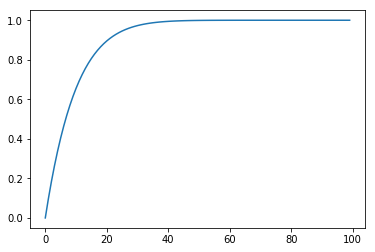

In [72]:
plt.plot(1 - (1 - x)**n)

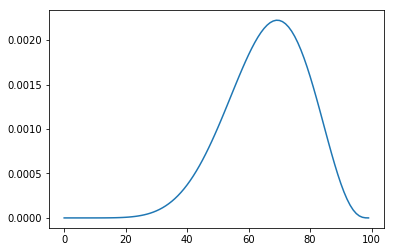

In [69]:
plt.plot(x**k * (1 - x)**(n-k))

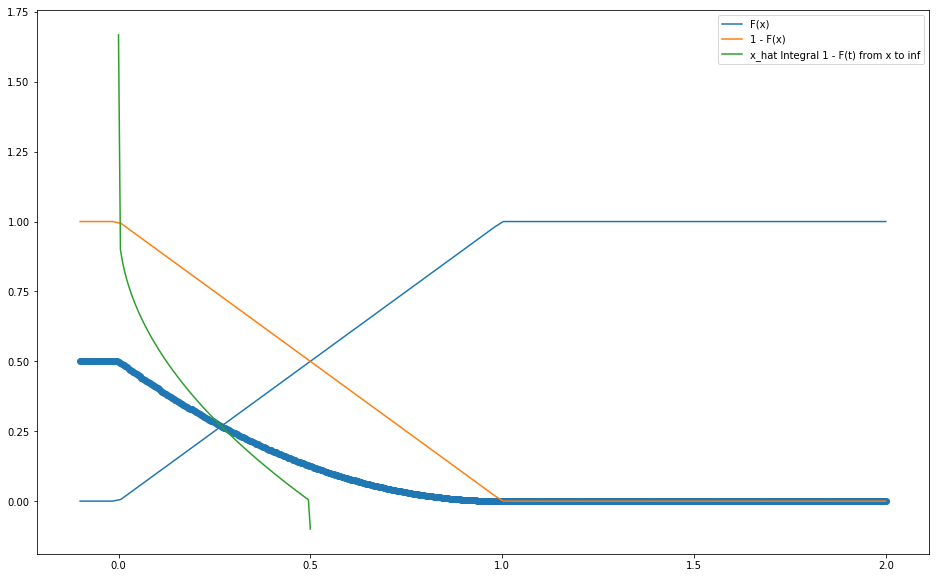

In [66]:
x_hat = Get_x_hat(F, verbose=True)

In [33]:
x = np.linspace(-0.1, 1.1, 100)

In [68]:
x_hat(np.array([1, 2]))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [69]:
y= [x_hat(t) for t in x]

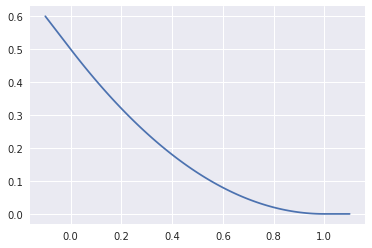

In [70]:
plt.plot(x, y)

In [130]:
x = np.linspace(-10с, 0, 11)

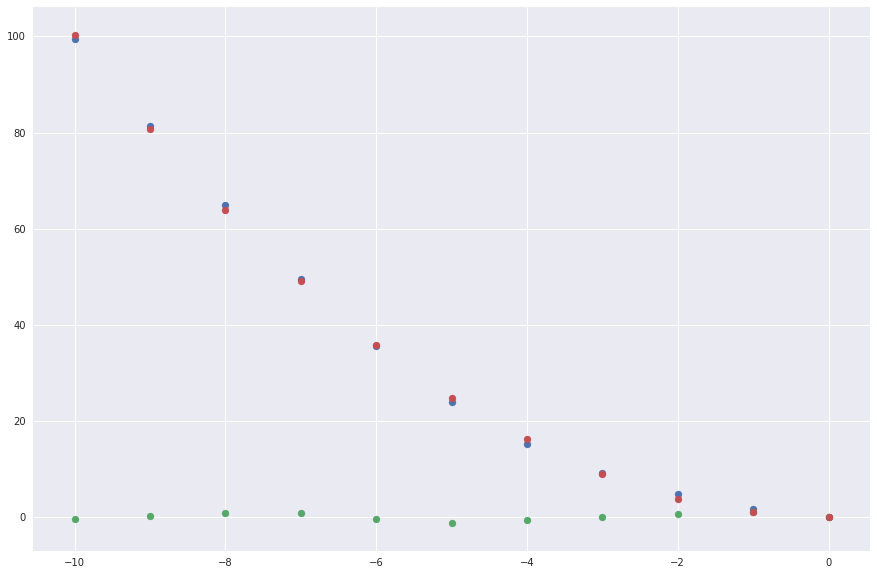

In [135]:
plt.figure(figsize=(15, 10))
plt.scatter(x, x**2 - np.sin(x))
plt.scatter(x, x**2 - np.sin(x) - x**2 - np.sin(2*x) / 4)
plt.scatter(x, x**2 - np.sin(2*x) / 4)

In [115]:
(349324 - 332824) / 250

66.0

In [116]:
66 / 62.5

1.056